# Data Preprocessing

The first step was understanding and visualizing the dataset. To do this we combined the data entries of the same timestamp for ozone and $PM_{2.5}$. The next step was to visualize the concentration and AQI for ozone as well as $PM_{2.5}$. Here we noticed missing values for certain timestamps as well as several outliers, especially for $PM_{2.5}$. The next step involves data pre-processing. Our first goal was outlier removal. For this, we calculated the inter-quartile range for each feature and all the values not lying in this range were set to zero. On these values and the ones that were already none, we use interpolation to have a rich dataset for model training.

We have experimented with several methods for interpolation namely: linear, polynomial and spline. For polynomial and spline we compare the performance of $3^{rd}$ and $5^{th}$ order functions as well. After visualizing the interpolated regions we found the best interpolated results for ozone and $PM_{2.5}$ with linear interpolation.



#### Import Libraries

In [ ]:
pip install openmeteo-requests

In [ ]:
pip install requests-cache retry-requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00


#### Import Libraries

In [ ]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Read the data using AirNow API

In [ ]:
# Extracting the data from airnow API
url = "https://www.airnowapi.org/aq/data/?startDate=2023-01-05T16&endDate=2023-12-8T23&parameters=OZONE,PM25,PM10,CO,NO2,SO2&BBOX=-80.00824,40.410183,-79.87022,40.480205&dataType=B&format=text/csv&verbose=0&monitorType=0&includerawconcentrations=0&API_KEY=FB304044-F68A-4362-A58B-770F0192D163"
df = pd.read_csv(url)
df.to_csv("AirNowAPIData.csv",index= False)
print("Data Extracted")

Data Extracted


In [ ]:
# Add column heading
column_names = ["Latitude", "Longitude", "Timestamp", "Pollutant", "Concentration", "Unit", "AQI", "AQI Category"]
# Read the data from the CSV file
data = pd.read_csv("/content/AirNowAPIData.csv",names=column_names)
# Display the DataFrame
data

,Latitude,Longitude,Timestamp,Pollutant,Concentration,Unit,AQI,AQI Category
0,40.4656,-79.9611,2023-01-05T16:00,PM2.5,8.8,UG/M3,37,1
1,40.4656,-79.9611,2023-01-05T16:00,OZONE,23.0,PPB,21,1
2,40.4656,-79.9611,2023-01-05T17:00,PM2.5,7.4,UG/M3,31,1
3,40.4656,-79.9611,2023-01-05T17:00,OZONE,25.0,PPB,23,1
4,40.4656,-79.9611,2023-01-05T18:00,OZONE,29.0,PPB,27,1
...,...,...,...,...,...,...,...,...
16038,40.4656,-79.9611,2023-12-08T21:00,PM2.5,4.9,UG/M3,20,1
16039,40.4656,-79.9611,2023-12-08T22:00,OZONE,31.0,PPB,29,1
16040,40.4656,-79.9611,2023-12-08T22:00,PM2.5,4.9,UG/M3,20,1
16041,40.4656,-79.9611,2023-12-08T23:00,PM2.5,6.3,UG/M3,26,1


In [ ]:
# Creating and storing filtered data by separating PM2.5 and OZONE values into different columns
# This filtering is useful for interpolating data used for data imputation
# ---------------------------------------------------------------------------------------------#

filtered_data = data[data['Pollutant'].isin(['PM2.5', 'OZONE'])]

# Separating PM2.5 and OZONE values into different columns
preprocessed_data = filtered_data.pivot(index=["Timestamp"], columns="Pollutant", values=["Concentration", "Unit", "AQI", "AQI Category"])
preprocessed_data.reset_index(inplace=True)

# Flattening the multi-level column names
preprocessed_data.columns = ['_'.join(col).strip() for col in preprocessed_data.columns.values]
preprocessed_data.rename(columns={"Timestamp_": "Timestamp", "Concentration_PM2.5": "PM2.5_Concentration", "Unit_PM2.5": "PM2.5_Unit ",
                         "AQI_PM2.5": "PM2.5_AQI", "AQI Category_PM2.5": "PM2.5_AQI_Category", "Concentration_OZONE": "Ozone_Concentration",
                         "Unit_OZONE": "Ozone_Unit", "AQI_OZONE": "Ozone_AQI", "AQI Category_OZONE": "Ozone_AQI_Category"}, inplace=True)

preprocessed_data.to_csv("/content/preprocessed_data.csv", index=False)
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8081 entries, 0 to 8080
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Timestamp            8081 non-null   object
 1   Ozone_Concentration  8062 non-null   object
 2   PM2.5_Concentration  7981 non-null   object
 3   Ozone_Unit           8062 non-null   object
 4   PM2.5_Unit           7981 non-null   object
 5   Ozone_AQI            8062 non-null   object
 6   PM2.5_AQI            7981 non-null   object
 7   Ozone_AQI_Category   8062 non-null   object
 8   PM2.5_AQI_Category   7981 non-null   object
dtypes: object(9)
memory usage: 568.3+ KB


In [ ]:
#Print information about the pre-processed data
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8081 entries, 0 to 8080
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Timestamp            8081 non-null   object
 1   Ozone_Concentration  8062 non-null   object
 2   PM2.5_Concentration  7981 non-null   object
 3   Ozone_Unit           8062 non-null   object
 4   PM2.5_Unit           7981 non-null   object
 5   Ozone_AQI            8062 non-null   object
 6   PM2.5_AQI            7981 non-null   object
 7   Ozone_AQI_Category   8062 non-null   object
 8   PM2.5_AQI_Category   7981 non-null   object
dtypes: object(9)
memory usage: 568.3+ KB


In [ ]:
#Change the data type of Timestamp to datetime
preprocessed_data['Timestamp']=pd.to_datetime(preprocessed_data['Timestamp'])
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8081 entries, 0 to 8080
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Timestamp            8081 non-null   datetime64[ns]
 1   Ozone_Concentration  8062 non-null   object        
 2   PM2.5_Concentration  7981 non-null   object        
 3   Ozone_Unit           8062 non-null   object        
 4   PM2.5_Unit           7981 non-null   object        
 5   Ozone_AQI            8062 non-null   object        
 6   PM2.5_AQI            7981 non-null   object        
 7   Ozone_AQI_Category   8062 non-null   object        
 8   PM2.5_AQI_Category   7981 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 568.3+ KB


In [ ]:
#Generating descriptive statistics of the pre-processed data to perform statistical analysis
preprocessed_data.describe()

<ipython-input-112-c82941d6e8a7>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  preprocessed_data.describe()


,Timestamp,Ozone_Concentration,PM2.5_Concentration,Ozone_Unit,PM2.5_Unit,Ozone_AQI,PM2.5_AQI,Ozone_AQI_Category,PM2.5_AQI_Category
count,8081,8062.0,7981.0,8062,7981,8062.0,7981.0,8062.0,7981.0
unique,8081,72.0,453.0,1,1,68.0,173.0,4.0,6.0
top,2023-01-05 16:00:00,24.0,6.5,PPB,UG/M3,31.0,28.0,1.0,1.0
freq,1,263.0,89.0,8062,7981,432.0,225.0,7955.0,5824.0
first,2023-01-05 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-12-08 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Set Timestamp to be the index which is useful for creating plots
data_for_plots = preprocessed_data.set_index('Timestamp')

# Analyzing Ozone Concentration

Text(0, 0.5, 'Ozone Concentration (PPB)')

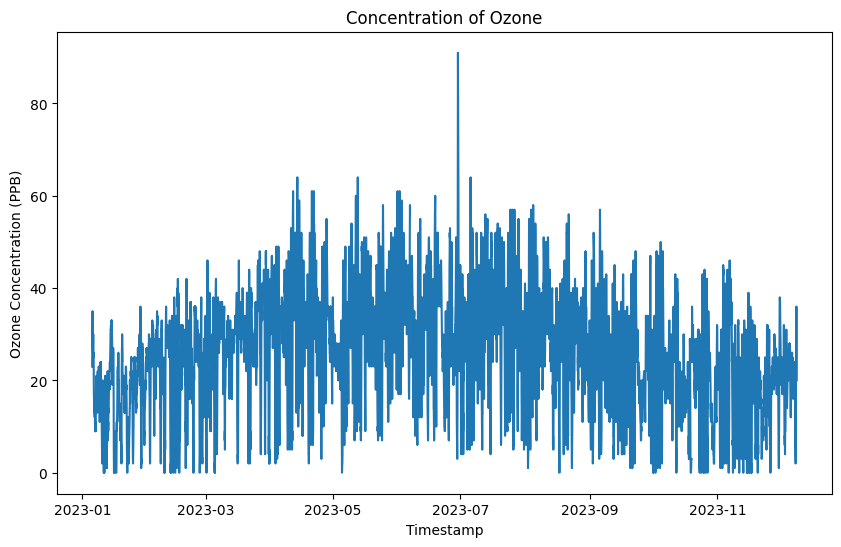

In [ ]:
# Plot the Ozone Concentration
plt.figure(figsize = (10,6))
plt.plot(data_for_plots['Ozone_Concentration'])
plt.title("Concentration of Ozone")
plt.xlabel("Timestamp")
plt.ylabel("Ozone Concentration (PPB)")

In [ ]:
#Finding indices with missing values for Ozone concentration
ozone_conc_missing = np.where(preprocessed_data.Ozone_Concentration.isnull())[0]
print(f'Indices with missing values of Ozone Concentration: {ozone_conc_missing}')

Indices with missing values of Ozone Concentration: [1872 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665 3666
 3667 6872 6873 6874 6875]


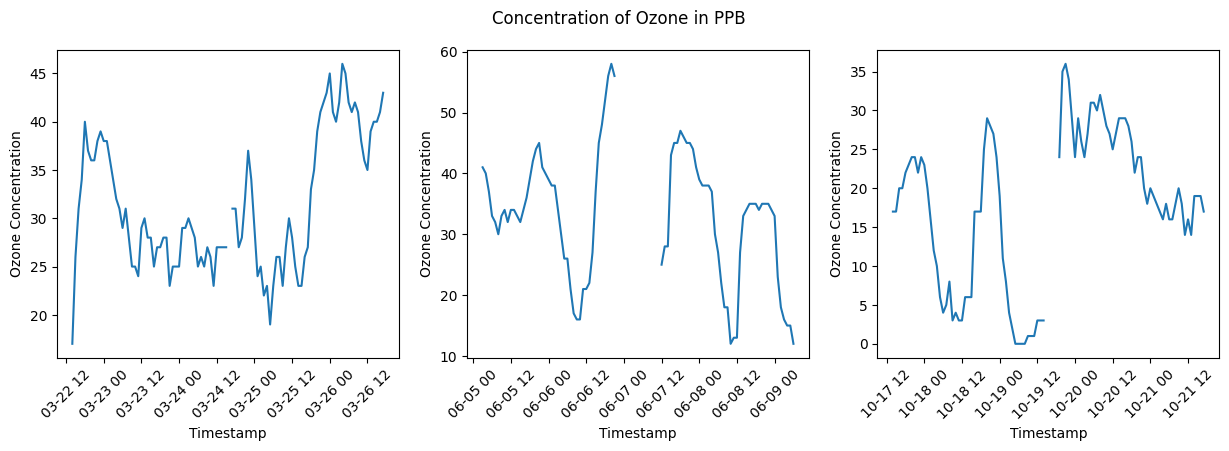

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with missing values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

# Analyzing PM2.5 Concentration

Text(0, 0.5, 'PM 2.5 Concentration (UG/M3)')

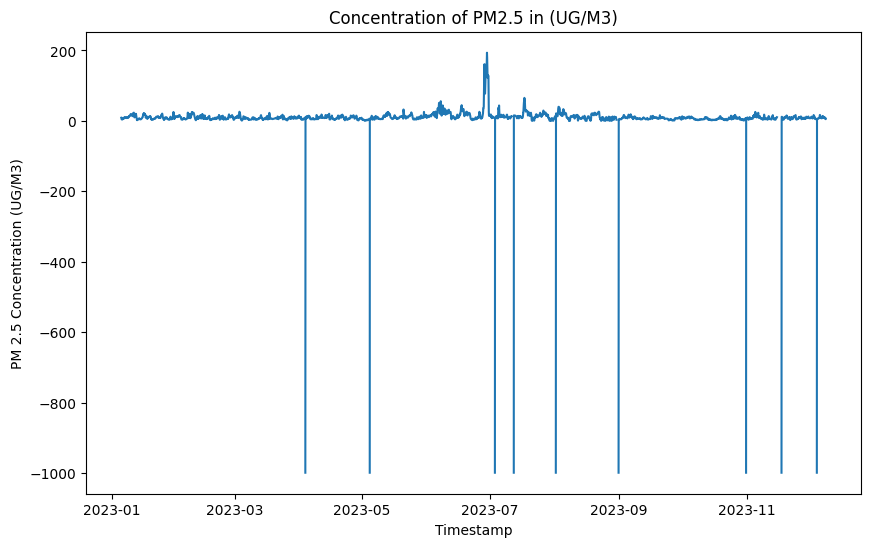

In [ ]:
# Plot the PM2.5 Concentration
plt.figure(figsize = (10,6))
plt.plot(data_for_plots['PM2.5_Concentration'])
plt.title("Concentration of PM2.5 in (UG/M3)")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5 Concentration (UG/M3)")

In [ ]:
# Setting negative PM2.5 Concentration values to null
preprocessed_data.loc[preprocessed_data['PM2.5_Concentration'] < 0, 'PM2.5_Concentration'] = np.NaN
data_for_plots.loc[data_for_plots['PM2.5_Concentration'] < 0, 'PM2.5_Concentration'] = np.NaN

In [ ]:
#Finding indices with missing values for PM2.5 concentration which is useful for plotting
pm25_conc_missing = np.where(preprocessed_data['PM2.5_Concentration'].isna())[0]
print(f'Indices with missing values of PM2.5 Concentration: {pm25_conc_missing}')

Indices with missing values of PM2.5 Concentration: [2114 2115 2854 2855 4282 4283 4476 4477 4478 4479 4480 4481 4482 4483
 4484 4485 4486 4487 4488 4489 4490 4491 4492 4493 4494 4495 4976 4977
 4978 5676 5677 5678 5679 5680 5681 5682 5683 5684 5685 5686 5687 5688
 5689 5690 5691 5692 5693 5694 5695 5696 5697 5698 5699 7163 7164 7520
 7521 7522 7523 7524 7525 7526 7527 7528 7529 7530 7531 7532 7533 7534
 7535 7536 7537 7538 7539 7540 7541 7542 7543 7544 7545 7546 7547 7548
 7549 7550 7551 7552 7553 7554 7555 7556 7557 7558 7559 7560 7561 7562
 7563 7564 7565 7566 7567 7568 7569 7570 7571 7976 7977]


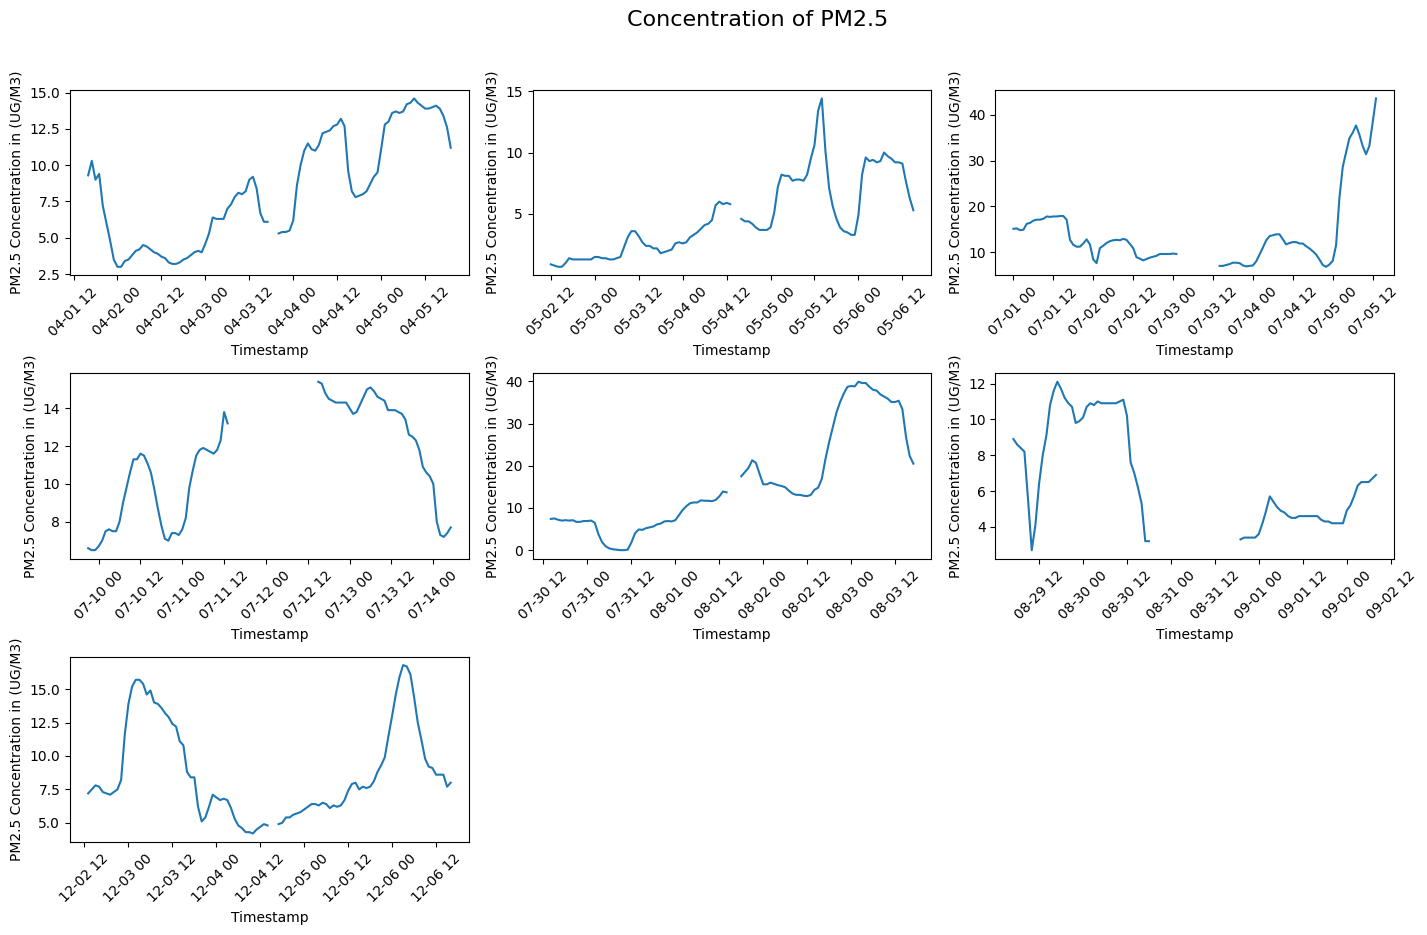

In [ ]:
# Picking the 1st index, followed by the 3rd, 5th, 16th, 28th, 41st and 54th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 2, 4, 15, 27, 41, -2]
#Visualize the timeseries for PM2.5 Concentration with missing values
plt.figure(figsize = (15, 10))
for i in range(0, len(picked_idx)):
  plt.subplot(3, 3, i+1)
  plt.plot(data_for_plots['PM2.5_Concentration'][pm25_conc_missing[picked_idx[i]] - 50 : pm25_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('PM2.5 Concentration in (UG/M3)')

plt.suptitle("Concentration of PM2.5", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 0.95, 0.95])  # Adjust the padding between and around subplots
plt.show()

# Analyzing Air Quality Index (AQI) of Ozone

Text(0, 0.5, 'Ozone AQI')

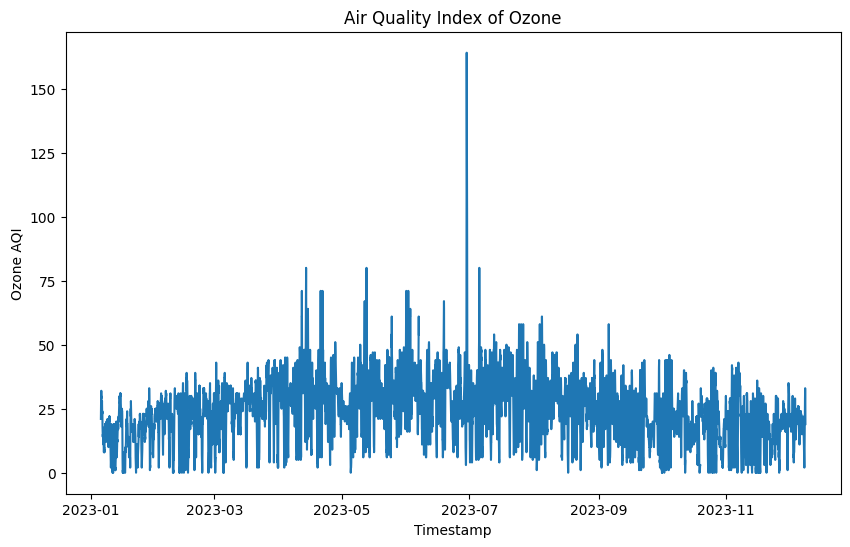

In [ ]:
# Plot the Ozone AQI
plt.figure(figsize = (10,6))
plt.plot(data_for_plots['Ozone_AQI'])
plt.title("Air Quality Index of Ozone")
plt.xlabel("Timestamp")
plt.ylabel("Ozone AQI")

In [ ]:
#Finding indices with missing values for Ozone AQI which is useful for plotting
ozone_aqi_missing = np.where(data_for_plots['Ozone_AQI'].isna())[0]
print(f'Indices with missing values of Ozone AQI: {ozone_aqi_missing}')

Indices with missing values of Ozone AQI: [1872 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665 3666
 3667 6872 6873 6874 6875]


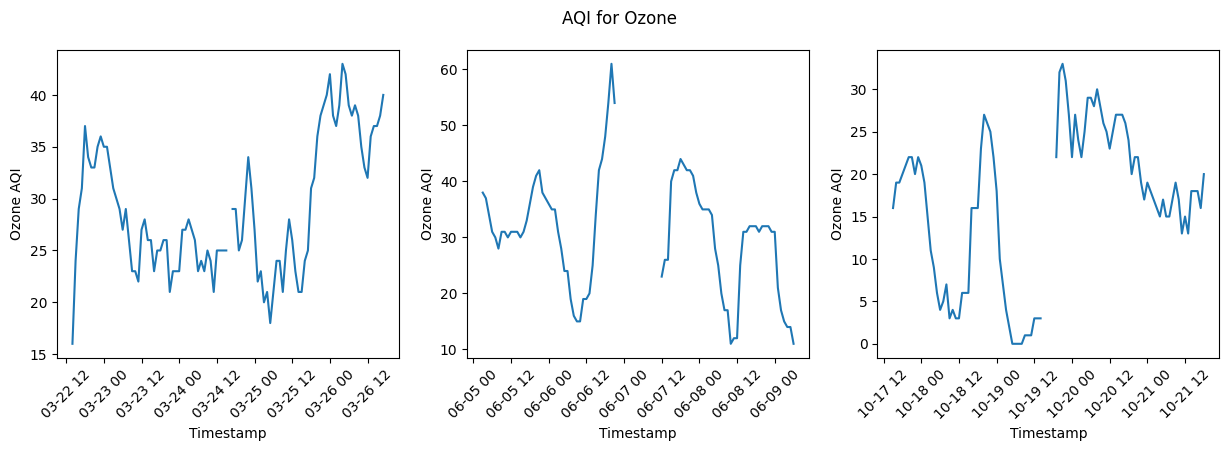

In [ ]:
# Picking the 1st index, followed by the 9th and 19th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -2]
#Visualize the timeseries for Ozone AQI with missing values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("AQI for Ozone")
  plt.plot(data_for_plots['Ozone_AQI'][ozone_aqi_missing[picked_idx[i]] - 50 : ozone_aqi_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone AQI')

# Analyzing Air Quality Index (AQI) of PM2.5

Text(0, 0.5, 'PM 2.5 AQI')

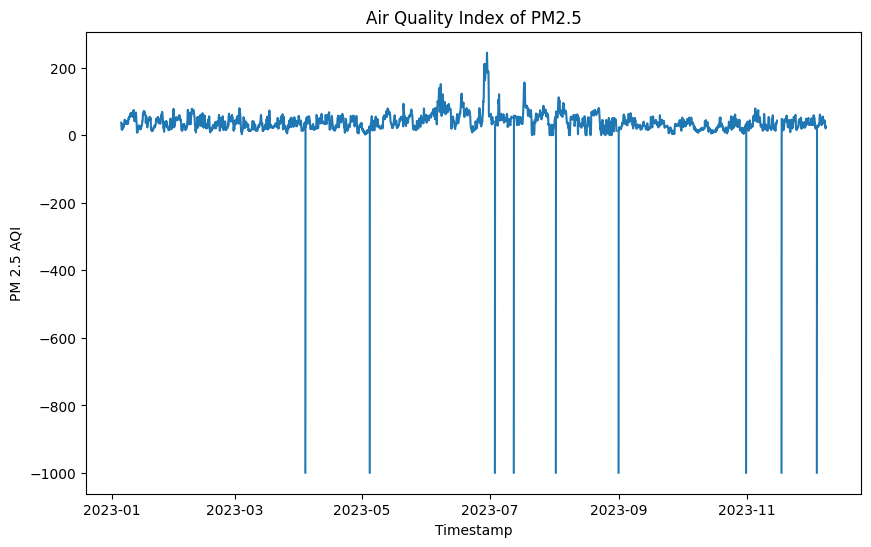

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(data_for_plots['PM2.5_AQI'])
plt.title("Air Quality Index of PM2.5")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5 AQI")

In [ ]:
# Setting negative PM2.5 AQI values to null
preprocessed_data.loc[preprocessed_data['PM2.5_AQI'] < 0, 'PM2.5_AQI'] = np.NaN
data_for_plots.loc[data_for_plots['PM2.5_AQI'] < 0, 'PM2.5_AQI'] = np.NaN

In [ ]:
#Finding indices with missing values for PM2.5 AQI which is useful for plotting
pm25_aqi_missing = np.where(preprocessed_data['PM2.5_AQI'].isna())[0]
print(f'Indices with missing values of PM2.5 AQI: {pm25_aqi_missing}')

Indices with missing values of PM2.5 AQI: [2114 2115 2854 2855 4282 4283 4476 4477 4478 4479 4480 4481 4482 4483
 4484 4485 4486 4487 4488 4489 4490 4491 4492 4493 4494 4495 4976 4977
 4978 5676 5677 5678 5679 5680 5681 5682 5683 5684 5685 5686 5687 5688
 5689 5690 5691 5692 5693 5694 5695 5696 5697 5698 5699 7163 7164 7520
 7521 7522 7523 7524 7525 7526 7527 7528 7529 7530 7531 7532 7533 7534
 7535 7536 7537 7538 7539 7540 7541 7542 7543 7544 7545 7546 7547 7548
 7549 7550 7551 7552 7553 7554 7555 7556 7557 7558 7559 7560 7561 7562
 7563 7564 7565 7566 7567 7568 7569 7570 7571 7976 7977]


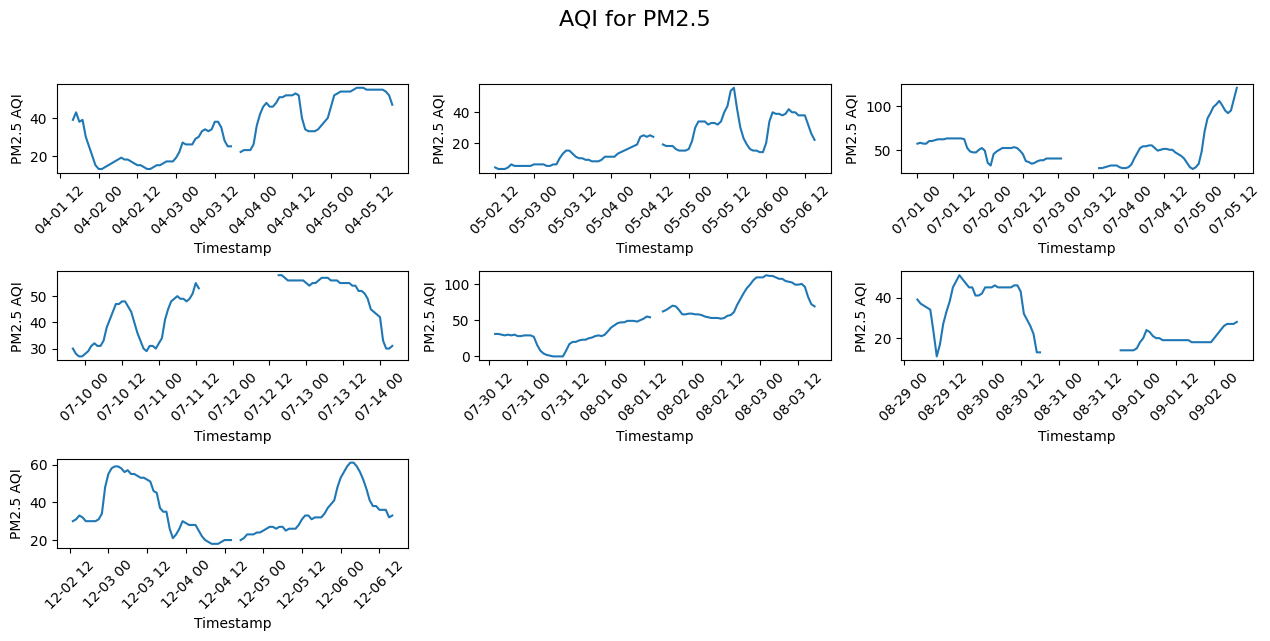

In [ ]:
# Picking the 1st index, followed by the 3rd, 5th, 15th, 28th, 41st and 54th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 2, 4, 14, 27, 40, -2]
#Visualize the timeseries for PM2.5 AQI with missing values
plt.figure(figsize = (16, 6.5))
for i in range(0, len(picked_idx)):
  plt.subplot(3, 3, i+1)
  plt.plot(data_for_plots['PM2.5_AQI'][pm25_aqi_missing[picked_idx[i]] - 50 : pm25_aqi_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('PM2.5 AQI')

plt.suptitle("AQI for PM2.5", fontsize=16, x =0.4)
plt.tight_layout(rect=[0, 0.001, 0.8, 0.95])
plt.show()

# Experiments for Interpolation used for Data Imputation

## Experiments for Interpolation with Ozone Concentration

### Linear Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")
#Perform Linear Interpolation
preprocessed_data.interpolate(method='linear', limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

In [ ]:
print(f'Indices with missing values of Ozone Concentration: {ozone_conc_missing}')

Indices with missing values of Ozone Concentration: [1872 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665 3666
 3667 6872 6873 6874 6875]


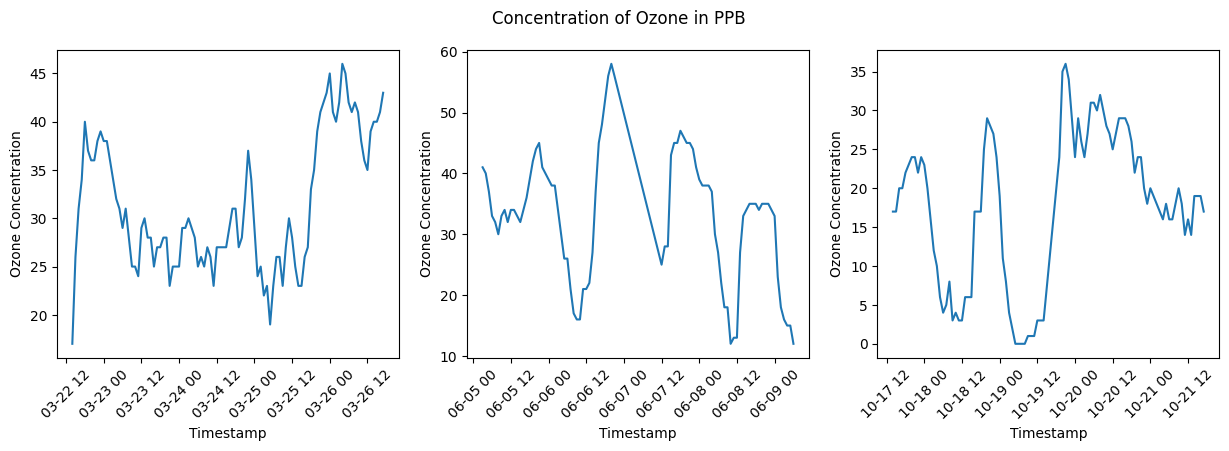

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with interpolated values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

### Sline Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")
#Perform Sline Interpolation
preprocessed_data.interpolate(method='slinear', limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

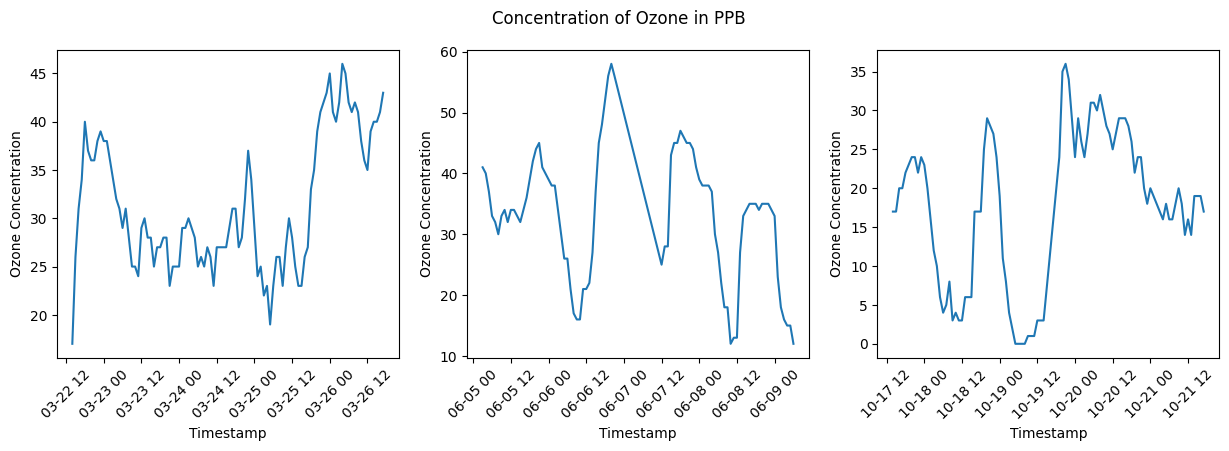

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with interpolated values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

### Spline 3 Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")
#Perform Spline 3 Interpolation
preprocessed_data.interpolate(method='spline', order=3,limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

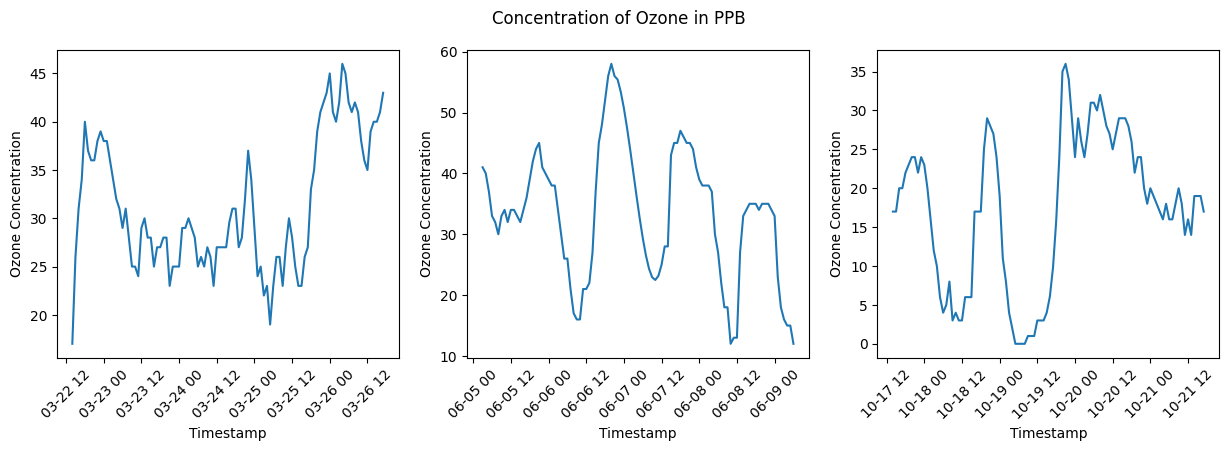

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with interpolated values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

### Spline 5 Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")
#Perform Spline 5 Interpolation
preprocessed_data.interpolate(method='spline', order=5, limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

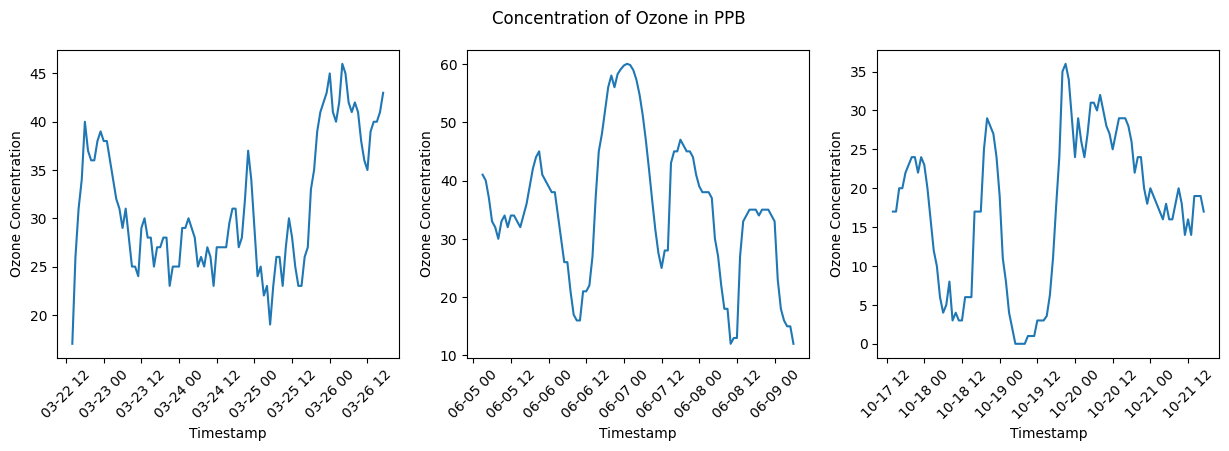

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with interpolated values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

### Polynomial 3 Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")
#Perform Spline 5 Interpolation
preprocessed_data.interpolate(method='polynomial', order=3, limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

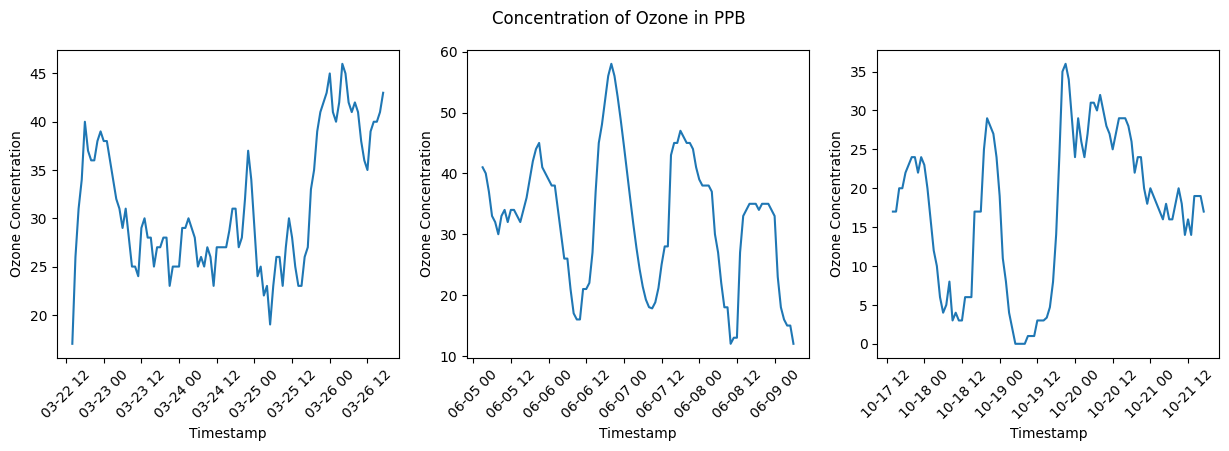

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with interpolated values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

### Polynomial 5 Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")
#Perform Spline 5 Interpolation
preprocessed_data.interpolate(method='polynomial', order=5, limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

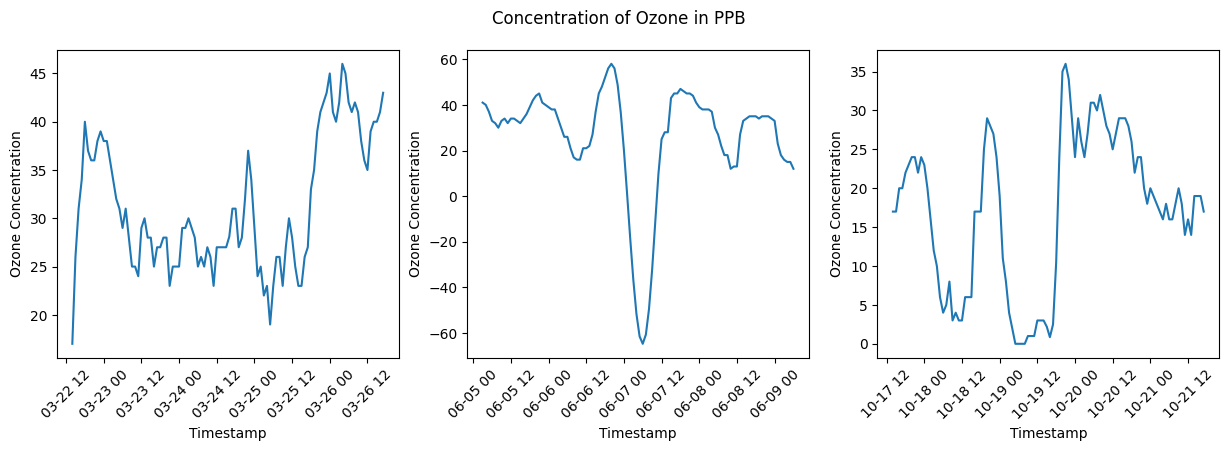

In [ ]:
# Picking the 1st index, followed by the 9th and 17th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 8, -3]
#Visualize the timeseries for Ozone Concentration with interpolated values
plt.figure(figsize = (15, 4))
for i in range(0, len(picked_idx)):
  plt.subplot(1, 3, i+1)
  plt.suptitle("Concentration of Ozone in PPB")
  plt.plot(data_for_plots['Ozone_Concentration'][ozone_conc_missing[picked_idx[i]] - 50 : ozone_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('Ozone Concentration')

##Experiments for Interpolation with PM 2.5 Concentration




### Spline 3 Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")

# Setting negative PM2.5 AQI values to null
preprocessed_data.loc[preprocessed_data['PM2.5_AQI'] < 0, 'PM2.5_AQI'] = np.NaN
# Setting negative PM2.5 Concentration values to null
preprocessed_data.loc[preprocessed_data['PM2.5_Concentration'] < 0, 'PM2.5_Concentration'] = np.NaN
#Perform Linear Interpolation
preprocessed_data.interpolate(method='spline',order=3, limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

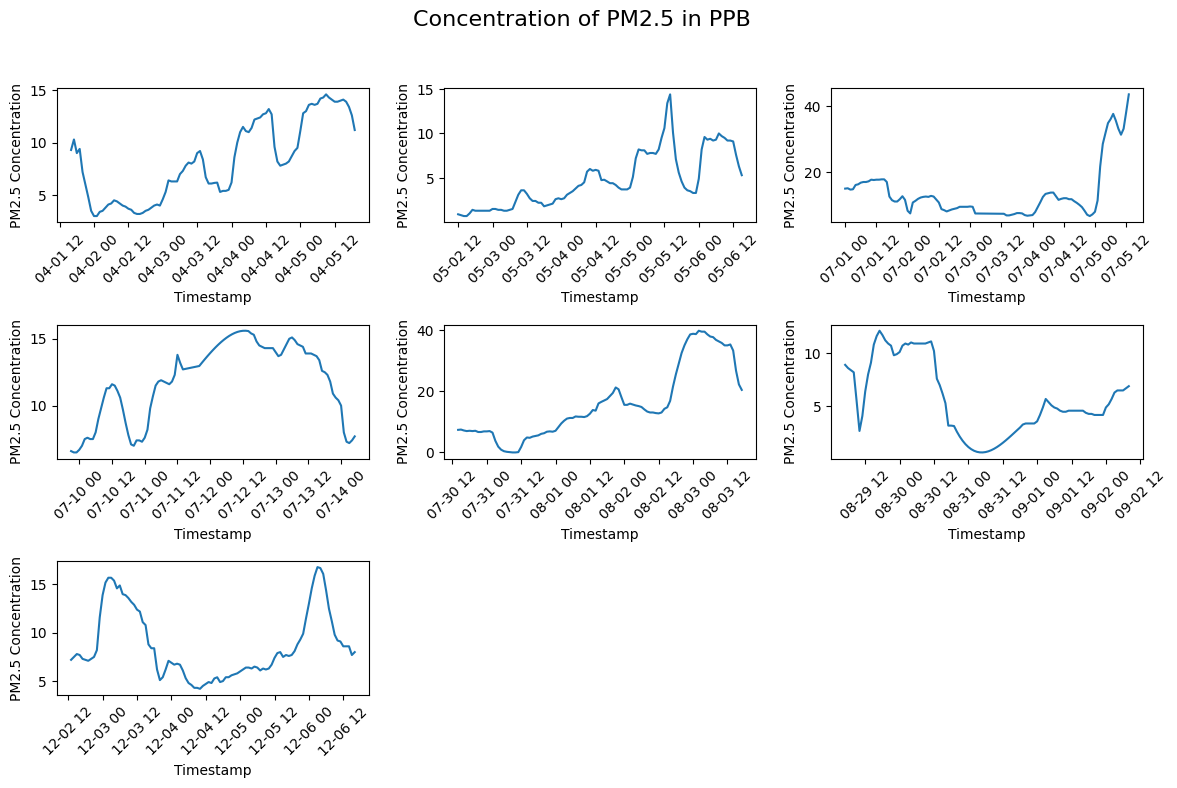

In [ ]:
# Picking the 1st index, followed by the 3rd, 5th, 16th, 28th, 41st and 54th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 2, 4, 15, 27, 41, -2]
#Visualize the timeseries for PM2.5 Concentration with interpolated values
plt.figure(figsize = (15, 8))
for i in range(0, len(picked_idx)):
  plt.subplot(3, 3, i+1)
  plt.plot(data_for_plots['PM2.5_Concentration'][pm25_conc_missing[picked_idx[i]] - 50 : pm25_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('PM2.5 Concentration')

plt.suptitle("Concentration of PM2.5 in PPB", fontsize=16, x =0.4)
plt.tight_layout(rect=[0, 0.001, 0.8, 0.95])
plt.show()

### Linear Interpolation

In [ ]:
# Read the data from the CSV file
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")

# Setting negative PM2.5 AQI values to null
preprocessed_data.loc[preprocessed_data['PM2.5_AQI'] < 0, 'PM2.5_AQI'] = np.NaN
# Setting negative PM2.5 Concentration values to null
preprocessed_data.loc[preprocessed_data['PM2.5_Concentration'] < 0, 'PM2.5_Concentration'] = np.NaN
#Perform Linear Interpolation
preprocessed_data.interpolate(method='linear',limit_direction='forward', axis=0,inplace=True)

In [ ]:
#Create data_for_plots useful for plotting timeseries
data_for_plots = preprocessed_data.copy()
data_for_plots['Timestamp']=pd.to_datetime(data_for_plots['Timestamp'])
data_for_plots = data_for_plots.set_index('Timestamp')

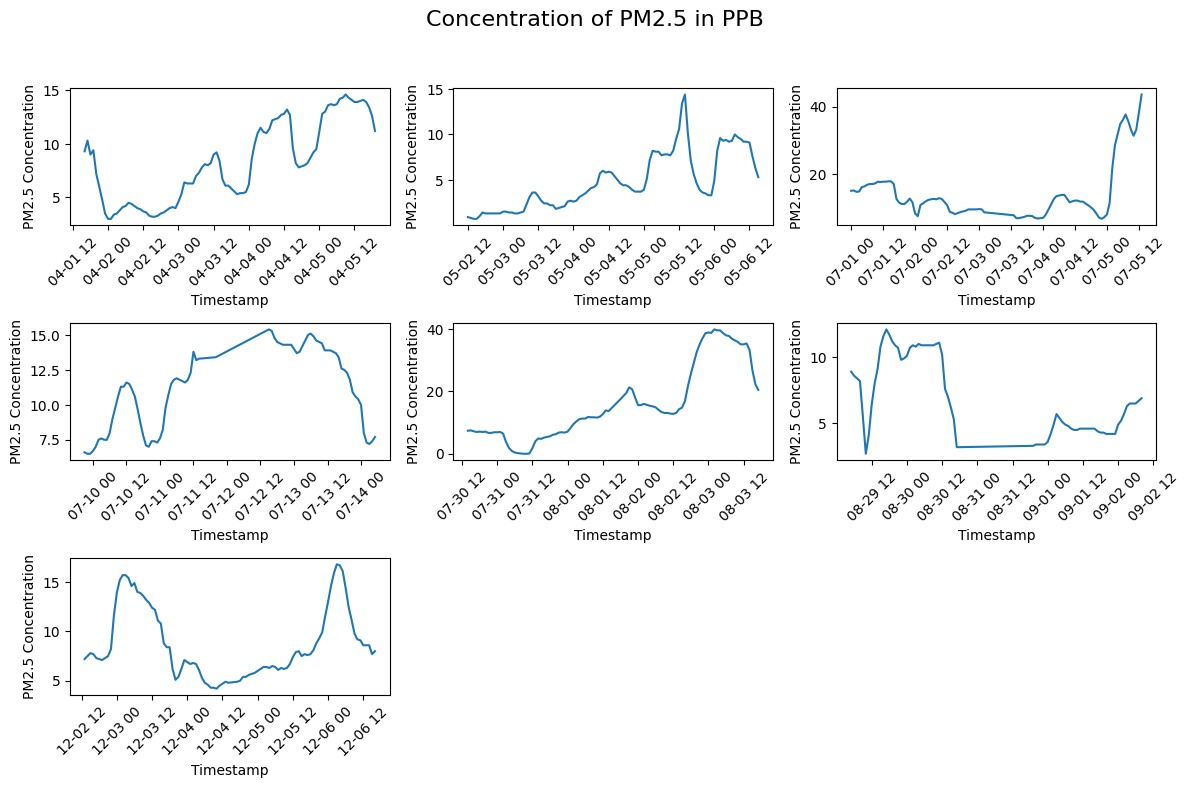

In [ ]:
# Picking the 1st index, followed by the 3rd, 5th, 16th, 28th, 41st and 54th indices as the values around it are consecutive so the plots would be similar
picked_idx =  [0, 2, 4, 15, 27, 41, -2]
#Visualize the timeseries for PM2.5 Concentration with interpolated values
plt.figure(figsize = (15, 8))
for i in range(0, len(picked_idx)):
  plt.subplot(3, 3, i+1)
  plt.plot(data_for_plots['PM2.5_Concentration'][pm25_conc_missing[picked_idx[i]] - 50 : pm25_conc_missing[picked_idx[i]] + 50])
  plt.xticks(rotation=45)
  plt.xlabel('Timestamp')
  plt.ylabel('PM2.5 Concentration')

plt.suptitle("Concentration of PM2.5 in PPB", fontsize=16, x =0.4)
plt.tight_layout(rect=[0, 0.001, 0.8, 0.95])
plt.show()

# Removing outliers and then interpolating

### Using Interquartile Range (IQR) for finding outliers

In [ ]:
# Calculating the interquartile range for the specific column name and setting all values not in this range as zero
def quartiles(df,col_name):
  Q1 = df[col_name].quantile(0.25)
  Q3 =df[col_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  print(f'Column name: {name}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

  # Setting values less than lower bound of inter-quartile range to 0
  df.loc[df[col_name] < lower_bound, col_name] = np.NaN
  # Setting values larger than upper bound of inter-quartile range to 0
  df.loc[df[col_name] > upper_bound, col_name] = np.NaN

  return df

In [ ]:
# Read the data from the CSV file and pass each column through quartiles function
preprocessed_data = pd.read_csv("/content/preprocessed_data.csv")

# Setting negative PM2.5 AQI values to null
preprocessed_data.loc[preprocessed_data['PM2.5_AQI'] < 0, 'PM2.5_AQI'] = np.NaN
# Setting negative PM2.5 Concentration values to null
preprocessed_data.loc[preprocessed_data['PM2.5_Concentration'] < 0, 'PM2.5_Concentration'] = np.NaN

names = ['PM2.5_Concentration', 'PM2.5_AQI', 'Ozone_Concentration', 'Ozone_AQI']

for name in names:
    preprocessed_data = quartiles(preprocessed_data,name)

Column name: PM2.5_Concentration, Lower Bound: -4.6499999999999995, Upper Bound: 22.95
Column name: PM2.5_AQI, Lower Bound: -18.0, Upper Bound: 94.0
Column name: Ozone_Concentration, Lower Bound: -8.5, Upper Bound: 59.5
Column name: Ozone_AQI, Lower Bound: -6.5, Upper Bound: 53.5


In [ ]:
#Using linear interpolation for data imputation
df_linear = preprocessed_data.interpolate(method='linear',limit_direction='forward', axis=0)
df_final = df_linear.copy()

### Final Data Visualization

Text(0, 0.5, 'Ozone Concentration (PPB)')

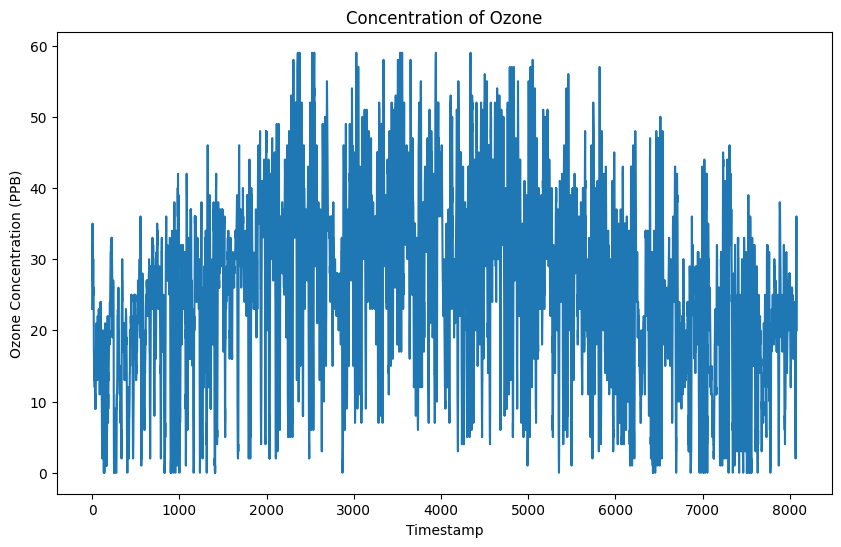

In [ ]:
# Plot the Ozone Concentration
plt.figure(figsize = (10,6))
plt.plot(df_final['Ozone_Concentration'])
plt.title("Concentration of Ozone")
plt.xlabel("Timestamp")
plt.ylabel("Ozone Concentration (PPB)")

Text(0, 0.5, 'AQI of Ozone')

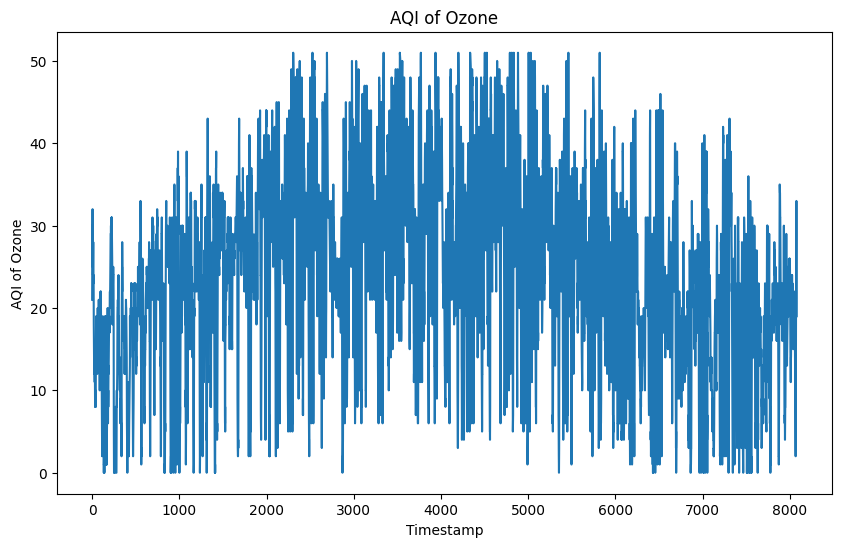

In [ ]:
# Plot the AQI of Ozone
plt.figure(figsize = (10,6))
plt.plot(df_final['Ozone_AQI'])
plt.title("AQI of Ozone")
plt.xlabel("Timestamp")
plt.ylabel("AQI of Ozone")

Text(0, 0.5, 'PM 2.5 Concentration (UG/M3)')

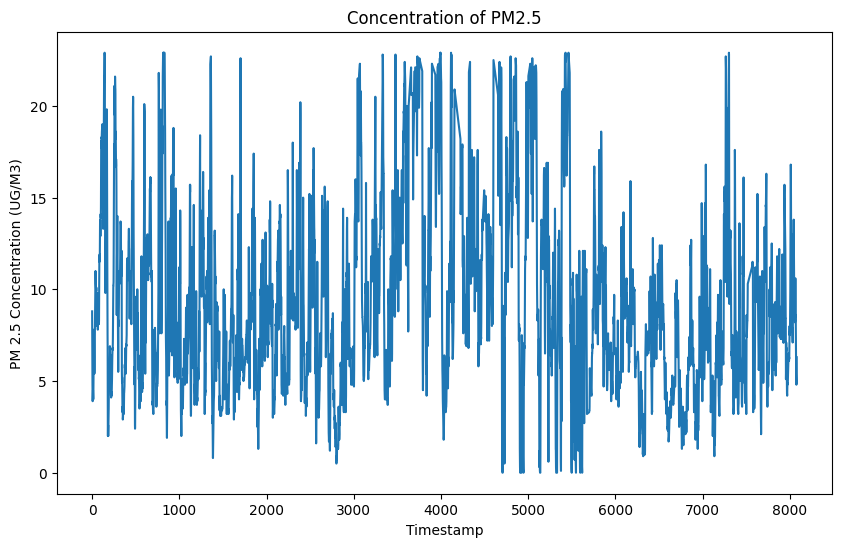

In [ ]:
# Plot the PM2.5 Concentration
plt.figure(figsize = (10,6))
plt.plot(df_final['PM2.5_Concentration'])
plt.title("Concentration of PM2.5")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5 Concentration (UG/M3)")

Text(0, 0.5, 'AQI of PM 2.5')

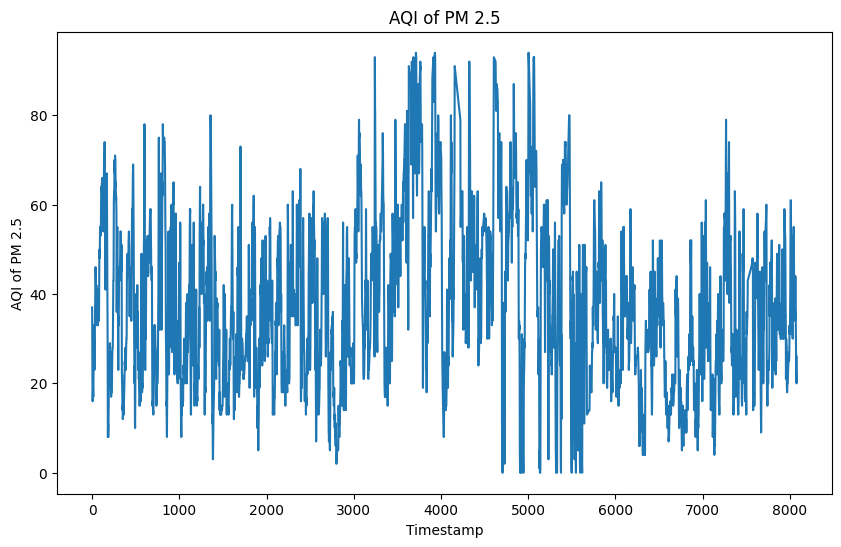

In [ ]:
# Plot the PM 2.5 AQI
plt.figure(figsize = (10,6))
plt.plot(df_final['PM2.5_AQI'])
plt.title("AQI of PM 2.5")
plt.xlabel("Timestamp")
plt.ylabel("AQI of PM 2.5")

In [ ]:
#Save the data after outlier removal and interpolation
df_final.to_csv("all_outlier_removed.csv",index=False)

#Additional Pollutant and Weather Data

The following code is for acquiring additional pollutant and weather data and pre-processing it to finally combine it with our original data.

Open-Meteo is an open-source weather API. AQI data is also available through the API.

#### API Call for Additional Pollutant data

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://air-quality-api.open-meteo.com/v1/air-quality"
params = {
	"latitude": 40.445194,
	"longitude": -79.93923,
	"hourly": ["pm10", "carbon_monoxide", "nitrogen_dioxide", "sulphur_dioxide"],
	"timezone": "GMT",
	"start_date": "2023-01-05",
	"end_date": "2023-12-08"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_pm10 = hourly.Variables(0).ValuesAsNumpy()
hourly_carbon_monoxide = hourly.Variables(1).ValuesAsNumpy()
hourly_nitrogen_dioxide = hourly.Variables(2).ValuesAsNumpy()
hourly_sulphur_dioxide = hourly.Variables(3).ValuesAsNumpy()

hourly_data = {"Timestamp": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["pm10"] = hourly_pm10
hourly_data["carbon_monoxide"] = hourly_carbon_monoxide
hourly_data["nitrogen_dioxide"] = hourly_nitrogen_dioxide
hourly_data["sulphur_dioxide"] = hourly_sulphur_dioxide

extra_AQI = pd.DataFrame(data = hourly_data)
print(extra_AQI)


Coordinates 40.40000915527344°E -80.0°N
Elevation 311.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
               Timestamp  pm10  carbon_monoxide  nitrogen_dioxide  \
0    2023-01-05 00:00:00   4.7            145.0         24.400000   
1    2023-01-05 01:00:00   4.2            146.0         21.450001   
2    2023-01-05 02:00:00   4.3            148.0         17.250000   
3    2023-01-05 03:00:00   5.2            151.0         12.750000   
4    2023-01-05 04:00:00   5.9            153.0         11.450000   
...                  ...   ...              ...               ...   
8107 2023-12-08 19:00:00   9.6            218.0          6.900000   
8108 2023-12-08 20:00:00  10.0            220.0          8.400000   
8109 2023-12-08 21:00:00  11.0            230.0         11.100000   
8110 2023-12-08 22:00:00  12.8            254.0         16.100000   
8111 2023-12-08 23:00:00  14.0            285.0         22.200001   

      sulphur_dioxide  
0                3.60  
1        

In [ ]:
extra_AQI.describe()

,pm10,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide
count,8112.000000,8112.000000,8112.000000,8112.000000
mean,16.448002,242.332596,12.940428,6.219662
std,13.251612,102.569649,11.960004,3.464568
min,0.800000,95.000000,0.000000,0.000000
25%,8.600000,178.000000,5.300000,3.700000
50%,13.000000,221.000000,8.900000,5.700000
75%,20.200001,275.000000,15.700000,8.000000
max,153.199997,1125.000000,87.300003,38.500000


In [ ]:
extra_AQI.to_csv("extra_AQI.csv", index=False)

In [ ]:
# Calculating the interquartile range for the specific column name and setting all values not in this range as zero
def quartiles(df,col_name):
  Q1 = df[col_name].quantile(0.25)
  Q3 =df[col_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  print(f'Column name: {col_name}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

  # Setting values less than lower bound of inter-quartile range to 0
  df.loc[df[col_name] < lower_bound, col_name] = np.NaN
  # Setting values larger than upper bound of inter-quartile range to 0
  df.loc[df[col_name] > upper_bound, col_name] = np.NaN

  return df

In [ ]:
# Read the data from the CSV file and pass each column through quartiles function
preprocessed_data = pd.read_csv("extra_AQI.csv")

names = ['pm10', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide']

for name in names:
    preprocessed_data = quartiles(preprocessed_data,name)

Column name: pm10, Lower Bound: -8.799999999999999, Upper Bound: 37.599999999999994
Column name: carbon_monoxide, Lower Bound: 32.5, Upper Bound: 420.5
Column name: nitrogen_dioxide, Lower Bound: -10.299999999999997, Upper Bound: 31.299999999999997
Column name: sulphur_dioxide, Lower Bound: -2.749999999999999, Upper Bound: 14.45


In [ ]:
#Using linear interpolation for data imputation
AQI_linear = preprocessed_data.interpolate(method='linear',limit_direction='forward', axis=0)
AQI_final = AQI_linear.copy()

In [ ]:
AQI_final.describe()

,pm10,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide
count,8112.000000,8112.000000,8112.000000,8112.000000
mean,15.290348,233.579204,11.391362,6.106053
std,8.936365,72.016362,7.910112,3.068945
min,0.800000,95.000000,0.000000,0.000000
25%,8.600000,178.000000,5.300000,3.700000
50%,13.000000,221.000000,8.900000,5.700000
75%,20.200000,275.000000,15.700000,8.000000
max,37.500000,420.000000,31.200000,14.400000


The timestamp in the data from Open-meteo is different from that in the data from AirNow. So it has to be formatted since the data is combined based on timestamps.

In [ ]:
AQI_final['Timestamp'].dtypes

dtype('O')

In [ ]:
AQI_final['Timestamp'] = AQI_final['Timestamp'].astype(str)
AQI_final['Timestamp'] = AQI_final['Timestamp'].str.replace(' ', 'T')
AQI_final['Timestamp'] = AQI_final['Timestamp'].str[:-3]

In [ ]:
AQI_final

,Timestamp,pm10,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide
0,2023-01-05T00:00,4.7,145.0,24.40,3.60
1,2023-01-05T01:00,4.2,146.0,21.45,3.65
2,2023-01-05T02:00,4.3,148.0,17.25,3.75
3,2023-01-05T03:00,5.2,151.0,12.75,4.00
4,2023-01-05T04:00,5.9,153.0,11.45,4.45
...,...,...,...,...,...
8107,2023-12-08T19:00,9.6,218.0,6.90,11.80
8108,2023-12-08T20:00,10.0,220.0,8.40,12.10
8109,2023-12-08T21:00,11.0,230.0,11.10,12.00
8110,2023-12-08T22:00,12.8,254.0,16.10,11.50


In [ ]:
AQI_final.to_csv("AQI.csv", index=False)

#### API call for weather data

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.445194,
	"longitude": -79.93923,
	"start_date": "2023-01-05",
	"end_date": "2023-12-08",
	"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "wind_speed_10m"],
	"timezone": "GMT"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()

hourly_data = {"Timestamp": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m

weather = pd.DataFrame(data = hourly_data)
print(weather)


Coordinates 40.456939697265625°E -79.97177124023438°N
Elevation 311.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
               Timestamp  temperature_2m  relative_humidity_2m  dew_point_2m  \
0    2023-01-05 00:00:00       13.387000             90.042717     11.787001   
1    2023-01-05 01:00:00       12.387000             86.441887     10.187000   
2    2023-01-05 02:00:00       11.587001             87.530388      9.587001   
3    2023-01-05 03:00:00       10.287001             90.113739      8.737000   
4    2023-01-05 04:00:00        9.287001             92.836449      8.187000   
...                  ...             ...                   ...           ...   
8107 2023-12-08 19:00:00       13.237000             40.054813     -0.063000   
8108 2023-12-08 20:00:00       13.187000             40.331696     -0.013000   
8109 2023-12-08 21:00:00       11.937000             46.382702      0.787000   
8110 2023-12-08 22:00:00        9.137000             54.107761      0.33

In [ ]:
weather.describe()

,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m
count,8112.000000,8112.000000,8112.000000,8112.000000
mean,12.648557,70.258675,6.709830,10.589934
std,8.902048,19.357275,8.747416,5.389412
min,-11.662999,11.866973,-22.263000,0.000000
25%,5.387000,55.700724,-0.263000,6.638072
50%,13.037001,72.590591,6.987000,9.659814
75%,19.837000,87.251871,14.337001,13.627795
max,33.586998,100.000000,23.837000,40.654503


In [ ]:
weather.to_csv("weather.csv", index=False)

In [ ]:
# Calculating the interquartile range for the specific column name and setting all values not in this range as zero
def quartiles(df,col_name):
  Q1 = df[col_name].quantile(0.25)
  Q3 =df[col_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  print(f'Column name: {col_name}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

  # Setting values less than lower bound of inter-quartile range to 0
  df.loc[df[col_name] < lower_bound, col_name] = np.NaN
  # Setting values larger than upper bound of inter-quartile range to 0
  df.loc[df[col_name] > upper_bound, col_name] = np.NaN

  return df

In [ ]:
# Read the data from the CSV file and pass each column through quartiles function
preprocessed_data = pd.read_csv("weather.csv")

names = ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'wind_speed_10m']

for name in names:
    preprocessed_data = quartiles(preprocessed_data,name)

Column name: temperature_2m, Lower Bound: -16.287999999999997, Upper Bound: 41.512
Column name: relative_humidity_2m, Lower Bound: 8.374003749999993, Upper Bound: 134.57858975
Column name: dew_point_2m, Lower Bound: -22.163001500000004, Upper Bound: 36.2370025
Column name: wind_speed_10m, Lower Bound: -3.8465125000000002, Upper Bound: 24.112379500000003


In [ ]:
#Using linear interpolation for data imputation
weather_linear = preprocessed_data.interpolate(method='linear',limit_direction='forward', axis=0)
weather_final = weather_linear.copy()

In [ ]:
weather_final.describe()

,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m
count,8112.000000,8112.000000,8112.000000,8112.000000
mean,12.648557,70.258674,6.709867,10.496166
std,8.902048,19.357276,8.747295,5.123318
min,-11.662999,11.866973,-22.063000,0.000000
25%,5.387000,55.700723,-0.263000,6.638072
50%,13.037001,72.590593,6.987000,9.659814
75%,19.837000,87.251870,14.337001,13.627795
max,33.586998,100.000000,23.837000,24.087738


In [ ]:
weather_final.to_csv("weather.csv", index=False)

#### Combine original AQI data with additional weather data

In [ ]:
#read the pre-processed original data for combining with additional data
AQI= pd.read_csv("all_outlier_removed.csv")

In [ ]:
AQI.describe()

,Ozone_Concentration,PM2.5_Concentration,Ozone_AQI,PM2.5_AQI,Ozone_AQI_Category,PM2.5_AQI_Category
count,8081.000000,8081.000000,8081.000000,8081.000000,8081.000000,8081.000000
mean,25.662171,9.671173,23.711236,38.499691,1.015221,-6.006497
std,12.963975,5.372762,11.880865,19.487489,0.132866,71.166756
min,0.000000,0.000000,0.000000,0.000000,1.000000,-999.000000
25%,17.000000,5.700000,16.000000,24.000000,1.000000,1.000000
50%,26.000000,8.600000,24.000000,36.000000,1.000000,1.000000
75%,34.000000,12.600000,31.000000,52.000000,1.000000,2.000000
max,59.000000,22.900000,51.000000,94.000000,4.000000,5.000000


The timestamp in the data from Open-meteo is different from that in the data from AirNow. So it has to be formatted since the data is combined based on timestamps.

In [ ]:
weather_final['Timestamp'].dtypes

dtype('O')

In [ ]:
weather_final['Timestamp'] = weather_final['Timestamp'].astype(str)
weather_final['Timestamp'] = weather_final['Timestamp'].str.replace(' ', 'T')
weather_final['Timestamp'] = weather_final['Timestamp'].str[:-3]

In [ ]:
weather_final

,Timestamp,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m
0,2023-01-05T00:00,13.387000,90.042720,11.787001,13.979872
1,2023-01-05T01:00,12.387000,86.441890,10.187000,14.332340
2,2023-01-05T02:00,11.587001,87.530390,9.587001,15.141414
3,2023-01-05T03:00,10.287001,90.113740,8.737000,17.313717
4,2023-01-05T04:00,9.287001,92.836450,8.187000,10.483357
...,...,...,...,...,...
8107,2023-12-08T19:00,13.237000,40.054813,-0.063000,14.618837
8108,2023-12-08T20:00,13.187000,40.331696,-0.013000,13.004921
8109,2023-12-08T21:00,11.937000,46.382700,0.787000,9.726665
8110,2023-12-08T22:00,9.137000,54.107760,0.337000,9.422101


In [ ]:
AQI

,Timestamp,Ozone_Concentration,PM2.5_Concentration,Ozone_Unit,PM2.5_Unit,Ozone_AQI,PM2.5_AQI,Ozone_AQI_Category,PM2.5_AQI_Category
0,2023-01-05T16:00,23.0,8.8,PPB,UG/M3,21.0,37.0,1.0,1.0
1,2023-01-05T17:00,25.0,7.4,PPB,UG/M3,23.0,31.0,1.0,1.0
2,2023-01-05T18:00,29.0,6.1,PPB,UG/M3,27.0,25.0,1.0,1.0
3,2023-01-05T19:00,32.0,5.4,PPB,UG/M3,30.0,23.0,1.0,1.0
4,2023-01-05T20:00,31.0,4.8,PPB,UG/M3,29.0,20.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
8076,2023-12-08T19:00,34.0,5.1,PPB,UG/M3,31.0,21.0,1.0,1.0
8077,2023-12-08T20:00,36.0,4.8,PPB,UG/M3,33.0,20.0,1.0,1.0
8078,2023-12-08T21:00,34.0,4.9,PPB,UG/M3,31.0,20.0,1.0,1.0
8079,2023-12-08T22:00,31.0,4.9,PPB,UG/M3,29.0,20.0,1.0,1.0


In [ ]:
AQI['Timestamp'].dtypes

dtype('O')

In [ ]:
AQI['Timestamp'] = AQI['Timestamp'].astype(str)

In [ ]:
other_new= AQI.join(weather_final.set_index('Timestamp'), on='Timestamp')

In [ ]:
other_new

,Timestamp,Ozone_Concentration,PM2.5_Concentration,Ozone_Unit,PM2.5_Unit,Ozone_AQI,PM2.5_AQI,Ozone_AQI_Category,PM2.5_AQI_Category,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m
0,2023-01-05T16:00,23.0,8.8,PPB,UG/M3,21.0,37.0,1.0,1.0,6.637000,64.139565,0.337,11.119281
1,2023-01-05T17:00,25.0,7.4,PPB,UG/M3,23.0,31.0,1.0,1.0,7.637000,55.498592,-0.713,10.685391
2,2023-01-05T18:00,29.0,6.1,PPB,UG/M3,27.0,25.0,1.0,1.0,8.537001,47.459873,-2.013,13.896187
3,2023-01-05T19:00,32.0,5.4,PPB,UG/M3,30.0,23.0,1.0,1.0,8.937000,45.517456,-2.213,13.608762
4,2023-01-05T20:00,31.0,4.8,PPB,UG/M3,29.0,20.0,1.0,1.0,8.887000,43.686733,-2.813,14.021525
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8076,2023-12-08T19:00,34.0,5.1,PPB,UG/M3,31.0,21.0,1.0,1.0,13.237000,40.054813,-0.063,14.618837
8077,2023-12-08T20:00,36.0,4.8,PPB,UG/M3,33.0,20.0,1.0,1.0,13.187000,40.331696,-0.013,13.004921
8078,2023-12-08T21:00,34.0,4.9,PPB,UG/M3,31.0,20.0,1.0,1.0,11.937000,46.382700,0.787,9.726665
8079,2023-12-08T22:00,31.0,4.9,PPB,UG/M3,29.0,20.0,1.0,1.0,9.137000,54.107760,0.337,9.422101


In [ ]:
other_new.describe()

,Ozone_Concentration,PM2.5_Concentration,Ozone_AQI,PM2.5_AQI,Ozone_AQI_Category,PM2.5_AQI_Category,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m
count,8081.000000,8081.000000,8081.000000,8081.000000,8081.000000,8081.000000,8081.000000,8081.000000,8081.000000,8081.000000
mean,25.662171,9.671173,23.711236,38.499691,1.015221,-6.006497,12.641263,70.197463,6.690682,10.501286
std,12.963975,5.372762,11.880865,19.487489,0.132866,71.166756,8.903244,19.336986,8.749286,5.128367
min,0.000000,0.000000,0.000000,0.000000,1.000000,-999.000000,-11.662999,11.866973,-22.063000,0.000000
25%,17.000000,5.700000,16.000000,24.000000,1.000000,1.000000,5.387000,55.643036,-0.313000,6.638072
50%,26.000000,8.600000,24.000000,36.000000,1.000000,1.000000,13.037001,72.501170,6.987000,9.659814
75%,34.000000,12.600000,31.000000,52.000000,1.000000,2.000000,19.837000,87.160630,14.287001,13.661038
max,59.000000,22.900000,51.000000,94.000000,4.000000,5.000000,33.586998,100.000000,23.837000,24.087738


#### Combine additional AQI (pollutant) data with orginal AQI data and weather data

In [ ]:
extra_AQI=pd.read_csv("AQI.csv")

In [ ]:
extra_AQI

,Timestamp,pm10,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide
0,2023-01-05T00:00,4.7,145.0,24.40,3.60
1,2023-01-05T01:00,4.2,146.0,21.45,3.65
2,2023-01-05T02:00,4.3,148.0,17.25,3.75
3,2023-01-05T03:00,5.2,151.0,12.75,4.00
4,2023-01-05T04:00,5.9,153.0,11.45,4.45
...,...,...,...,...,...
8107,2023-12-08T19:00,9.6,218.0,6.90,11.80
8108,2023-12-08T20:00,10.0,220.0,8.40,12.10
8109,2023-12-08T21:00,11.0,230.0,11.10,12.00
8110,2023-12-08T22:00,12.8,254.0,16.10,11.50


In [ ]:
latest= other_new.join(extra_AQI.set_index('Timestamp'), on='Timestamp')

In [ ]:
latest

,Timestamp,Ozone_Concentration,PM2.5_Concentration,Ozone_Unit,PM2.5_Unit,Ozone_AQI,PM2.5_AQI,Ozone_AQI_Category,PM2.5_AQI_Category,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,pm10,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide
0,2023-01-05T16:00,23.0,8.8,PPB,UG/M3,21.0,37.0,1.0,1.0,6.637000,64.139565,0.337,11.119281,3.8,154.0,10.10,7.00
1,2023-01-05T17:00,25.0,7.4,PPB,UG/M3,23.0,31.0,1.0,1.0,7.637000,55.498592,-0.713,10.685391,3.8,147.0,7.40,5.85
2,2023-01-05T18:00,29.0,6.1,PPB,UG/M3,27.0,25.0,1.0,1.0,8.537001,47.459873,-2.013,13.896187,3.8,140.0,4.95,4.65
3,2023-01-05T19:00,32.0,5.4,PPB,UG/M3,30.0,23.0,1.0,1.0,8.937000,45.517456,-2.213,13.608762,3.7,135.0,3.85,4.45
4,2023-01-05T20:00,31.0,4.8,PPB,UG/M3,29.0,20.0,1.0,1.0,8.887000,43.686733,-2.813,14.021525,3.6,132.0,3.40,4.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8076,2023-12-08T19:00,34.0,5.1,PPB,UG/M3,31.0,21.0,1.0,1.0,13.237000,40.054813,-0.063,14.618837,9.6,218.0,6.90,11.80
8077,2023-12-08T20:00,36.0,4.8,PPB,UG/M3,33.0,20.0,1.0,1.0,13.187000,40.331696,-0.013,13.004921,10.0,220.0,8.40,12.10
8078,2023-12-08T21:00,34.0,4.9,PPB,UG/M3,31.0,20.0,1.0,1.0,11.937000,46.382700,0.787,9.726665,11.0,230.0,11.10,12.00
8079,2023-12-08T22:00,31.0,4.9,PPB,UG/M3,29.0,20.0,1.0,1.0,9.137000,54.107760,0.337,9.422101,12.8,254.0,16.10,11.50


In [ ]:
columns_to_drop = ['Ozone_Unit','Ozone_AQI_Category','PM2.5_AQI_Category']
latest = latest.drop(columns=columns_to_drop)

In [ ]:
latest

,Timestamp,Ozone_Concentration,PM2.5_Concentration,PM2.5_Unit,Ozone_AQI,PM2.5_AQI,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,pm10,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide
0,2023-01-05T16:00,23.0,8.8,UG/M3,21.0,37.0,6.637000,64.139565,0.337,11.119281,3.8,154.0,10.10,7.00
1,2023-01-05T17:00,25.0,7.4,UG/M3,23.0,31.0,7.637000,55.498592,-0.713,10.685391,3.8,147.0,7.40,5.85
2,2023-01-05T18:00,29.0,6.1,UG/M3,27.0,25.0,8.537001,47.459873,-2.013,13.896187,3.8,140.0,4.95,4.65
3,2023-01-05T19:00,32.0,5.4,UG/M3,30.0,23.0,8.937000,45.517456,-2.213,13.608762,3.7,135.0,3.85,4.45
4,2023-01-05T20:00,31.0,4.8,UG/M3,29.0,20.0,8.887000,43.686733,-2.813,14.021525,3.6,132.0,3.40,4.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8076,2023-12-08T19:00,34.0,5.1,UG/M3,31.0,21.0,13.237000,40.054813,-0.063,14.618837,9.6,218.0,6.90,11.80
8077,2023-12-08T20:00,36.0,4.8,UG/M3,33.0,20.0,13.187000,40.331696,-0.013,13.004921,10.0,220.0,8.40,12.10
8078,2023-12-08T21:00,34.0,4.9,UG/M3,31.0,20.0,11.937000,46.382700,0.787,9.726665,11.0,230.0,11.10,12.00
8079,2023-12-08T22:00,31.0,4.9,UG/M3,29.0,20.0,9.137000,54.107760,0.337,9.422101,12.8,254.0,16.10,11.50


In [ ]:
latest.to_csv("complete_data.csv", index=False)

Ccomplete_Data.csv has all the data (AQI+Pollutant_Weather data) needed for training the models

# Correlation Analysis of weather and pollutant data with PM2.5 and Ozone AQI

In [ ]:
data= pd.read_csv("complete_data.csv")

In [ ]:
print(data.head())
print(data.shape)
print(data.describe())

          Timestamp  Ozone_Concentration  PM2.5_Concentration PM2.5_Unit   \
0  2023-01-05T16:00                 23.0                  8.8       UG/M3   
1  2023-01-05T17:00                 25.0                  7.4       UG/M3   
2  2023-01-05T18:00                 29.0                  6.1       UG/M3   
3  2023-01-05T19:00                 32.0                  5.4       UG/M3   
4  2023-01-05T20:00                 31.0                  4.8       UG/M3   

   Ozone_AQI  PM2.5_AQI  temperature_2m  relative_humidity_2m  dew_point_2m  \
0       21.0       37.0        6.637000             64.139565         0.337   
1       23.0       31.0        7.637000             55.498592        -0.713   
2       27.0       25.0        8.537001             47.459873        -2.013   
3       30.0       23.0        8.937000             45.517456        -2.213   
4       29.0       20.0        8.887000             43.686733        -2.813   

   wind_speed_10m  pm10  carbon_monoxide  nitrogen_dioxide  su

In [ ]:
correlation_matrix = data[['pm10', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide','temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'wind_speed_10m', 'PM2.5_AQI']].corr()
print(correlation_matrix['PM2.5_AQI'])

pm10                    0.645150
carbon_monoxide         0.444638
nitrogen_dioxide        0.218273
sulphur_dioxide         0.264364
temperature_2m          0.246275
relative_humidity_2m    0.037180
dew_point_2m            0.248654
wind_speed_10m         -0.292263
PM2.5_AQI               1.000000
Name: PM2.5_AQI, dtype: float64


In [ ]:
correlation_matrix = data[['pm10', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide','temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'wind_speed_10m', 'Ozone_AQI','PM2.5_AQI']].corr()
print(correlation_matrix['Ozone_AQI'])

pm10                    0.048883
carbon_monoxide        -0.279309
nitrogen_dioxide       -0.459103
sulphur_dioxide        -0.043570
temperature_2m          0.503533
relative_humidity_2m   -0.573085
dew_point_2m            0.176649
wind_speed_10m          0.207831
Ozone_AQI               1.000000
PM2.5_AQI              -0.004662
Name: Ozone_AQI, dtype: float64


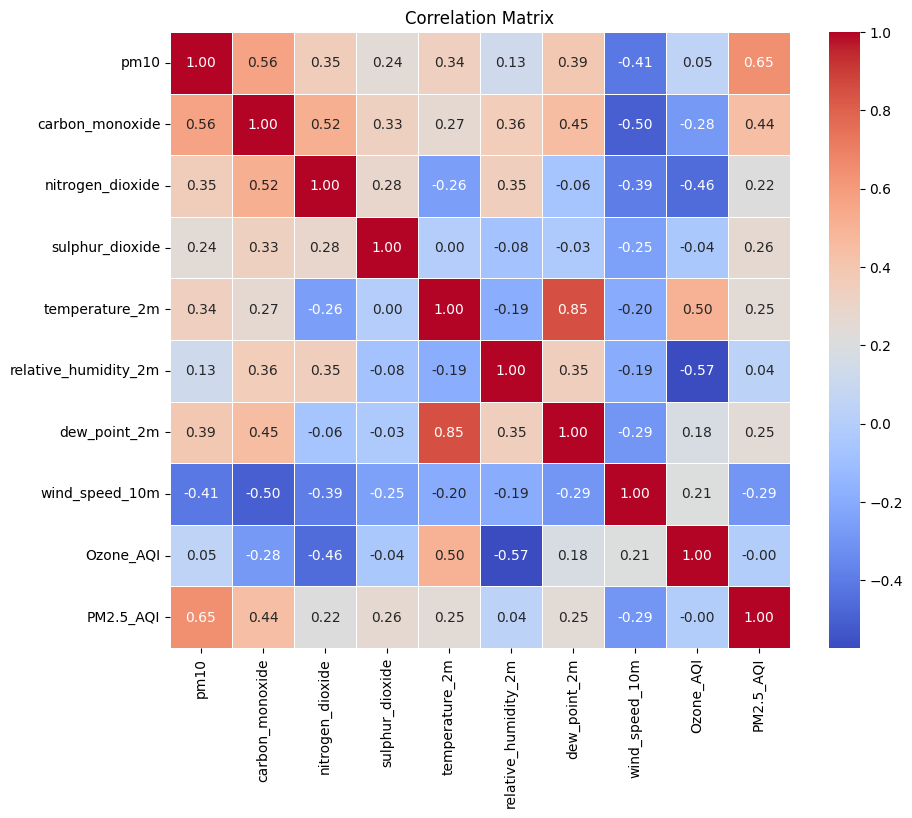

In [ ]:

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()